# VECTOR AUTOREGRESSION

This notebook aims to esplore some axpects of *VAR* in order to understand why the notebooks on SLDS inference do not work.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix  #to generate covariance matrices
from scipy.stats import special_ortho_group
from numpy.random import dirichlet
from scipy.stats import invwishart, matrix_normal
from numpy.linalg import inv,det
from numpy import sqrt
from tqdm import trange

seed = 123
np.random.seed(seed)

## Data Generation
Let's start generating data using an equation of the kind $x_t = Ax_{t-1} + \xi$ (with no offset), $\xi \sim \operatorname{N(0,Q)}$ then we will move on adding the offset.

In [34]:
# number of observable variables (coordinates of a 2-D motion)
M = 2

#number of samples you want to generate
N_samples = 1000

A_gen =  special_ortho_group.rvs(M)
Q_gen =  make_spd_matrix(M, random_state = seed)

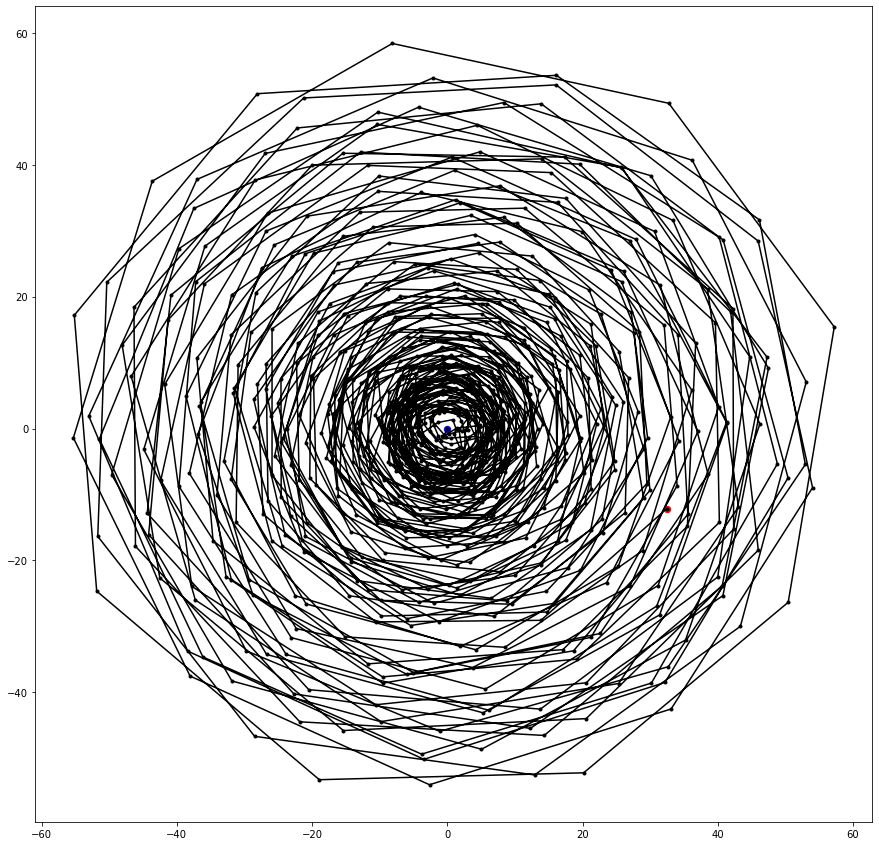

In [35]:
#### initializing the x time-serie
x_serie = np.zeros((M,N_samples))


for n in np.arange(N_samples - 1):
    
    #drawing noise from a normal
    noise = np.random.multivariate_normal(mean = np.zeros(M), cov = Q_gen, size = 1)
   
    x_serie[:,n + 1] = A_gen @ x_serie[:,n] + noise.flatten()
    
fig,ax = plt.subplots(1,1,figsize = [15,15])

ax.plot(x_serie[0,:], x_serie[1,:], marker = '.', color = 'black') 
ax.scatter(x_serie[0,-1], x_serie[1,-1], color = 'red', s = 40)
ax.scatter(x_serie[0,0], x_serie[1,0], color = 'blue', s= 40)

In [36]:
print('A matrix:','\n', A_gen)
print('Q matrix:','\n', Q_gen)

A matrix: 
 [[ 0.73641574 -0.67652927]
 [ 0.67652927  0.73641574]]
Q matrix: 
 [[ 2.5788794  -0.08195534]
 [-0.08195534  0.56369603]]


## DATA PREPARATION

In [37]:
#provo a riscrivere tutto utilizzando Y = XB + E nella regressione lineare, senza coordinate omogenee, senza offset
T = N_samples

#preparing data
X = x_serie[:, 0:T-1] #this X_{t-1} so times run between [0,T-1]

Y = x_serie[:, 1:T] #this is X_t so times run between [1,T], dimensions M x (T-1)

n_iterations = 2000 #number of iterations in the Gibbs sampler
burn_out = 500

#voglio seguire in tutto e per tutto le formule su wikipedia
Y = Y.T
X = X.T

print('X mean:',  X.mean(axis = 0),'\n')
print('Y mean:',  Y.mean(axis = 0),'\n')

#maybe here it is necessary to subtract the mean because I am considering no offset
X = X - X.mean(axis = 0)
Y = Y - Y.mean(axis = 0)

#ora A è MxM ed è il trasporto di quello con cui abbiamo generato i dati, Y è (T-1)xM, X è (T-1)xM 
print('X dimensions:', X.shape,'\n')
print('Y dimensions:', Y.shape,'\n')

X mean: [-0.00378362  0.00726898] 

Y mean: [ 0.02870526 -0.00489188] 

X dimensions: (999, 2) 

Y dimensions: (999, 2) 



## INFERENCE

In [38]:
#initialising

Q = np.zeros((n_iterations, M, M))        #covariance matrix
L = np.zeros((n_iterations, M, M))        #lambda parameter for matrix normal
V = np.zeros((n_iterations, M, M))        #V parameter for the inverse Wishart
nu = np.ones(n_iterations)*M             #nu parameter for inverse wishart, intialization wrong in inference_2
A = np.zeros((n_iterations, M, M)) 
Mn = np.zeros((n_iterations, M, M))       #mean matrix for matrix normal
             
#priors
             
L[0] = make_spd_matrix(M, random_state = seed)                      #I am not sure it is necessary to keep all the iterations
V[0] = make_spd_matrix(M, random_state = seed)
                                                                    #Mn has already been initialised
Q[0] = invwishart.rvs(df = nu[0], scale = V[0])                     #first approximation of variance matrix
A[0] = matrix_normal.rvs(mean = Mn[0],\
                                   rowcov = inv(L[0]), colcov = Q[0])
             
for it in trange(1, n_iterations):
                    
    L[it] = X.T @ X +  L[0]
    nu[it] = nu[0] + Y.shape[0]
             
    Mn[it] = inv(L[it]) @ (X.T @ Y + L[0] @ Mn[0])

    V[it] = V[0] + (Y - X @ Mn[it]).T @ (Y - X @ Mn[it]) +\
    (Mn[it] - Mn[0]).T @ L[0] @ (Mn[it] - Mn[0])

    Q[it] = invwishart.rvs(df = nu[it], scale =  V[it])
    A[it] = matrix_normal.rvs(mean = Mn[it], rowcov = inv(L[it]), colcov = Q[it])

100%|██████████| 1999/1999 [00:03<00:00, 533.91it/s]


In [39]:
print('inference A matrix:','\n', A[-1])       #questa è uguale a A_gen.T
print('inference Q matrix:','\n', Q[-1],'\n')  #questa è uguale a Q_gen 


####quindi questo funziona

inference A matrix: 
 [[ 0.74023374  0.67422921]
 [-0.67761599  0.73634924]]
inference Q matrix: 
 [[ 2.56509361 -0.04373542]
 [-0.04373542  0.51427822]] 

